<h1><center>Preparing a dataset for modeling</center></h1>

<h4><center>Emile Badran - U2 L1 P8</center></h4>

This notebook explores county-level data from the 2015 US Census, to determine if the county's median income is correlated to its population size.

- **Key metric of interest:**
    - to determine if a county's median income is correlated to its population size.


- ** Secondary metric of interest:**
    - to investigate if a county's jobs distribution by occupation affects median income.

The original dataset, [US 2015 Census Demographic and Economic Data for Tracts and Counties](https://www.kaggle.com/muonneutrino/us-census-demographic-data), contains information from the DP03 and DP05 tables of the 2015 American Community Survey 5-year estimates.

A subset of the data set's variables is selected. The subset is featured engineered and subjected to Principal Component Analysis (PCA) for future processing.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA 
import seaborn as sns
sns.set_style("white")
%matplotlib inline

# Configuring Jupyter to look nicer:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.options.display.max_columns = 37
import warnings
warnings.filterwarnings('ignore')

## Import data, filter variables, and process features of interest:

In [2]:
data = pd.read_csv('acs2015_census_tract_data.csv', encoding='latin-1')

# Drop rows with null values, as there aren't too many:
print('Ratio of rows with null values:',
      len(data[data.isnull().any(axis=1)])/len(data))
df = data.dropna()

# People who responded FamilyWork account for less than 1% of the population group
# their values are added to the SelfEmployed variable:
print('Average FamilyWork:', df['FamilyWork'].mean())
df.loc[:,'SelfEmployed'] = df.loc[:,['SelfEmployed','FamilyWork',]].sum(axis=1)

# Filter variables of interest:
df = df[['County','TotalPop','Income','Unemployment','Professional', 'Service', 'Office',
        'Construction', 'Production','PrivateWork','PublicWork','SelfEmployed']]

df.head(n=3)

Ratio of rows with null values: 0.017215983567789625
Average FamilyWork: 0.17010601289754773


,County,TotalPop,Income,Unemployment,Professional,Service,Office,Construction,Production,PrivateWork,PublicWork,SelfEmployed
0,Autauga,1948,61838.0,5.4,34.7,17.0,21.3,11.9,15.2,77.1,18.3,4.6
1,Autauga,2156,32303.0,13.3,22.3,24.7,21.5,9.4,22.0,77.0,16.9,6.1
2,Autauga,2968,44922.0,6.2,31.4,24.9,22.1,9.2,12.4,64.1,23.6,12.3


### Data is disaggregated by census track. Create a DataFrame with aggregated values for each county:

In [3]:
# Sum the TotalPop variable values for each county:
cty_data_sums = df[['County', 'TotalPop']].groupby('County').sum()

# Average the percentages of all other variables for each county:
cty_data_avgs = df[['County', 'Income','Unemployment','Professional', 'Service', 'Office',
        'Construction', 'Production','PrivateWork','PublicWork','SelfEmployed']].groupby('County').mean()

# Create a dataframe with values for each County:
dfc = pd.concat([cty_data_sums, cty_data_avgs], axis=1)

# Check that all columns have numeric values:
print('DataFrame shape:', dfc.shape,
      '\nNumeric columns and rows:', dfc._get_numeric_data().shape)

dfc.head(n=3)

DataFrame shape: (1926, 11) 
Numeric columns and rows: (1926, 11)


,TotalPop,Income,Unemployment,Professional,Service,Office,Construction,Production,PrivateWork,PublicWork,SelfEmployed
County,,,,,,,,,,,
Abbeville,24997,35159.833333,10.566667,24.700000,18.650000,19.483333,11.116667,26.083333,80.5000,13.100000,6.400000
Acadia,62163,39619.333333,9.941667,27.383333,18.291667,24.150000,14.675000,15.508333,82.7000,10.791667,6.533333
Accomack,33115,39467.000000,7.025000,32.312500,17.012500,21.425000,14.625000,14.625000,73.8125,17.662500,8.550000


**Data set metadata:**
- **TotalPop: **Total county population
- **Income: **average median income of the county's census tracks
- **Unemployment: **Unemployment rate (average of the county's census tracks)
- **Professional: **% employed in management, business, science, and arts (average of the county's census tracks)
- **Service: **% employed in service jobs (average of the county's census tracks)
- **Office: **% employed in sales and office jobs (average of the county's census tracks)
- **Construction: **% employed in natural resources, construction, and maintenance (average of the county's census tracks)
- **Production: **% employed in production, transportation, and material movement (average of the county's census tracks)
- **PrivateWork: **% employed in private industry (average of the county's census tracks)
- **PublicWork: **% employed in public jobs (average of the county's census tracks)
- **SelfEmployed: **% self-employed + % in unpaid family work (average of the county's census tracks)

## Standardize values and compare the distributions of all variables:

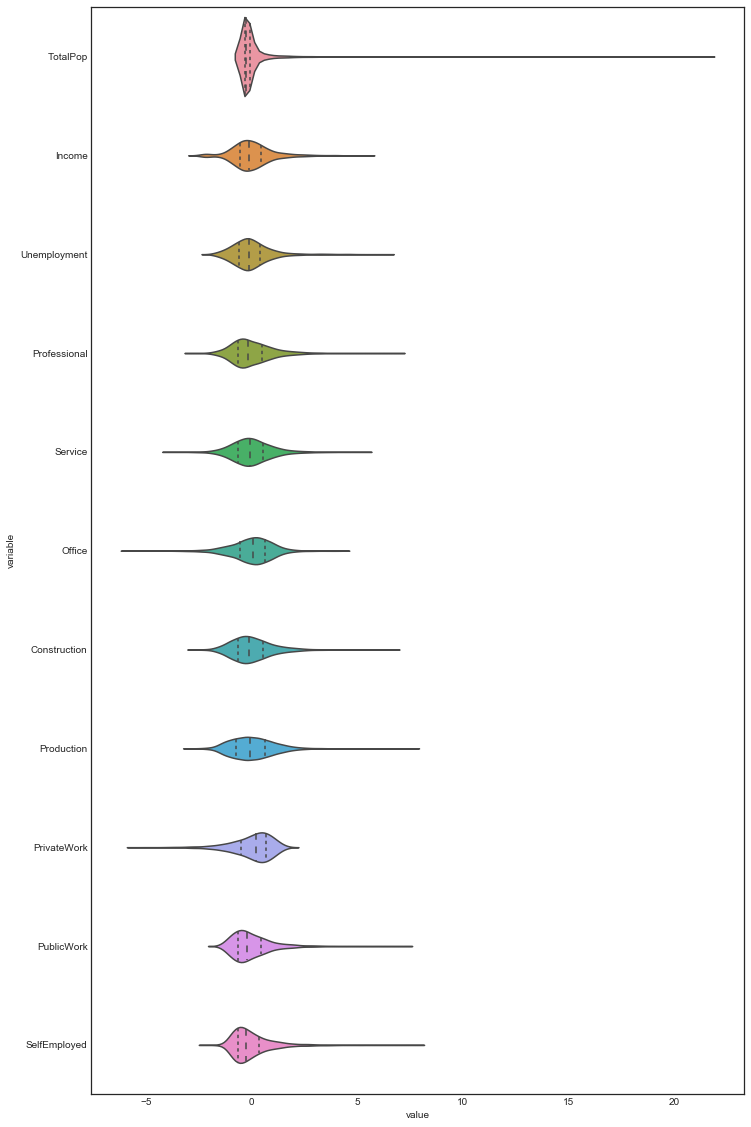

In [4]:
# Save the column names.
names=dfc.columns

# Scale, then turn the resulting numpy array back into a data frame with the
# correct column names.
dfs = pd.DataFrame(preprocessing.scale(dfc), columns=names)

# Plot a violin chart:
dfs['index_vals'] = list(dfs.index)
data_to_plot = pd.melt(
    dfs, id_vars='index_vals')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 20)

sns.violinplot(x="value", y="variable", data=data_to_plot, inner="quartile")

## Visualize variable correlations:

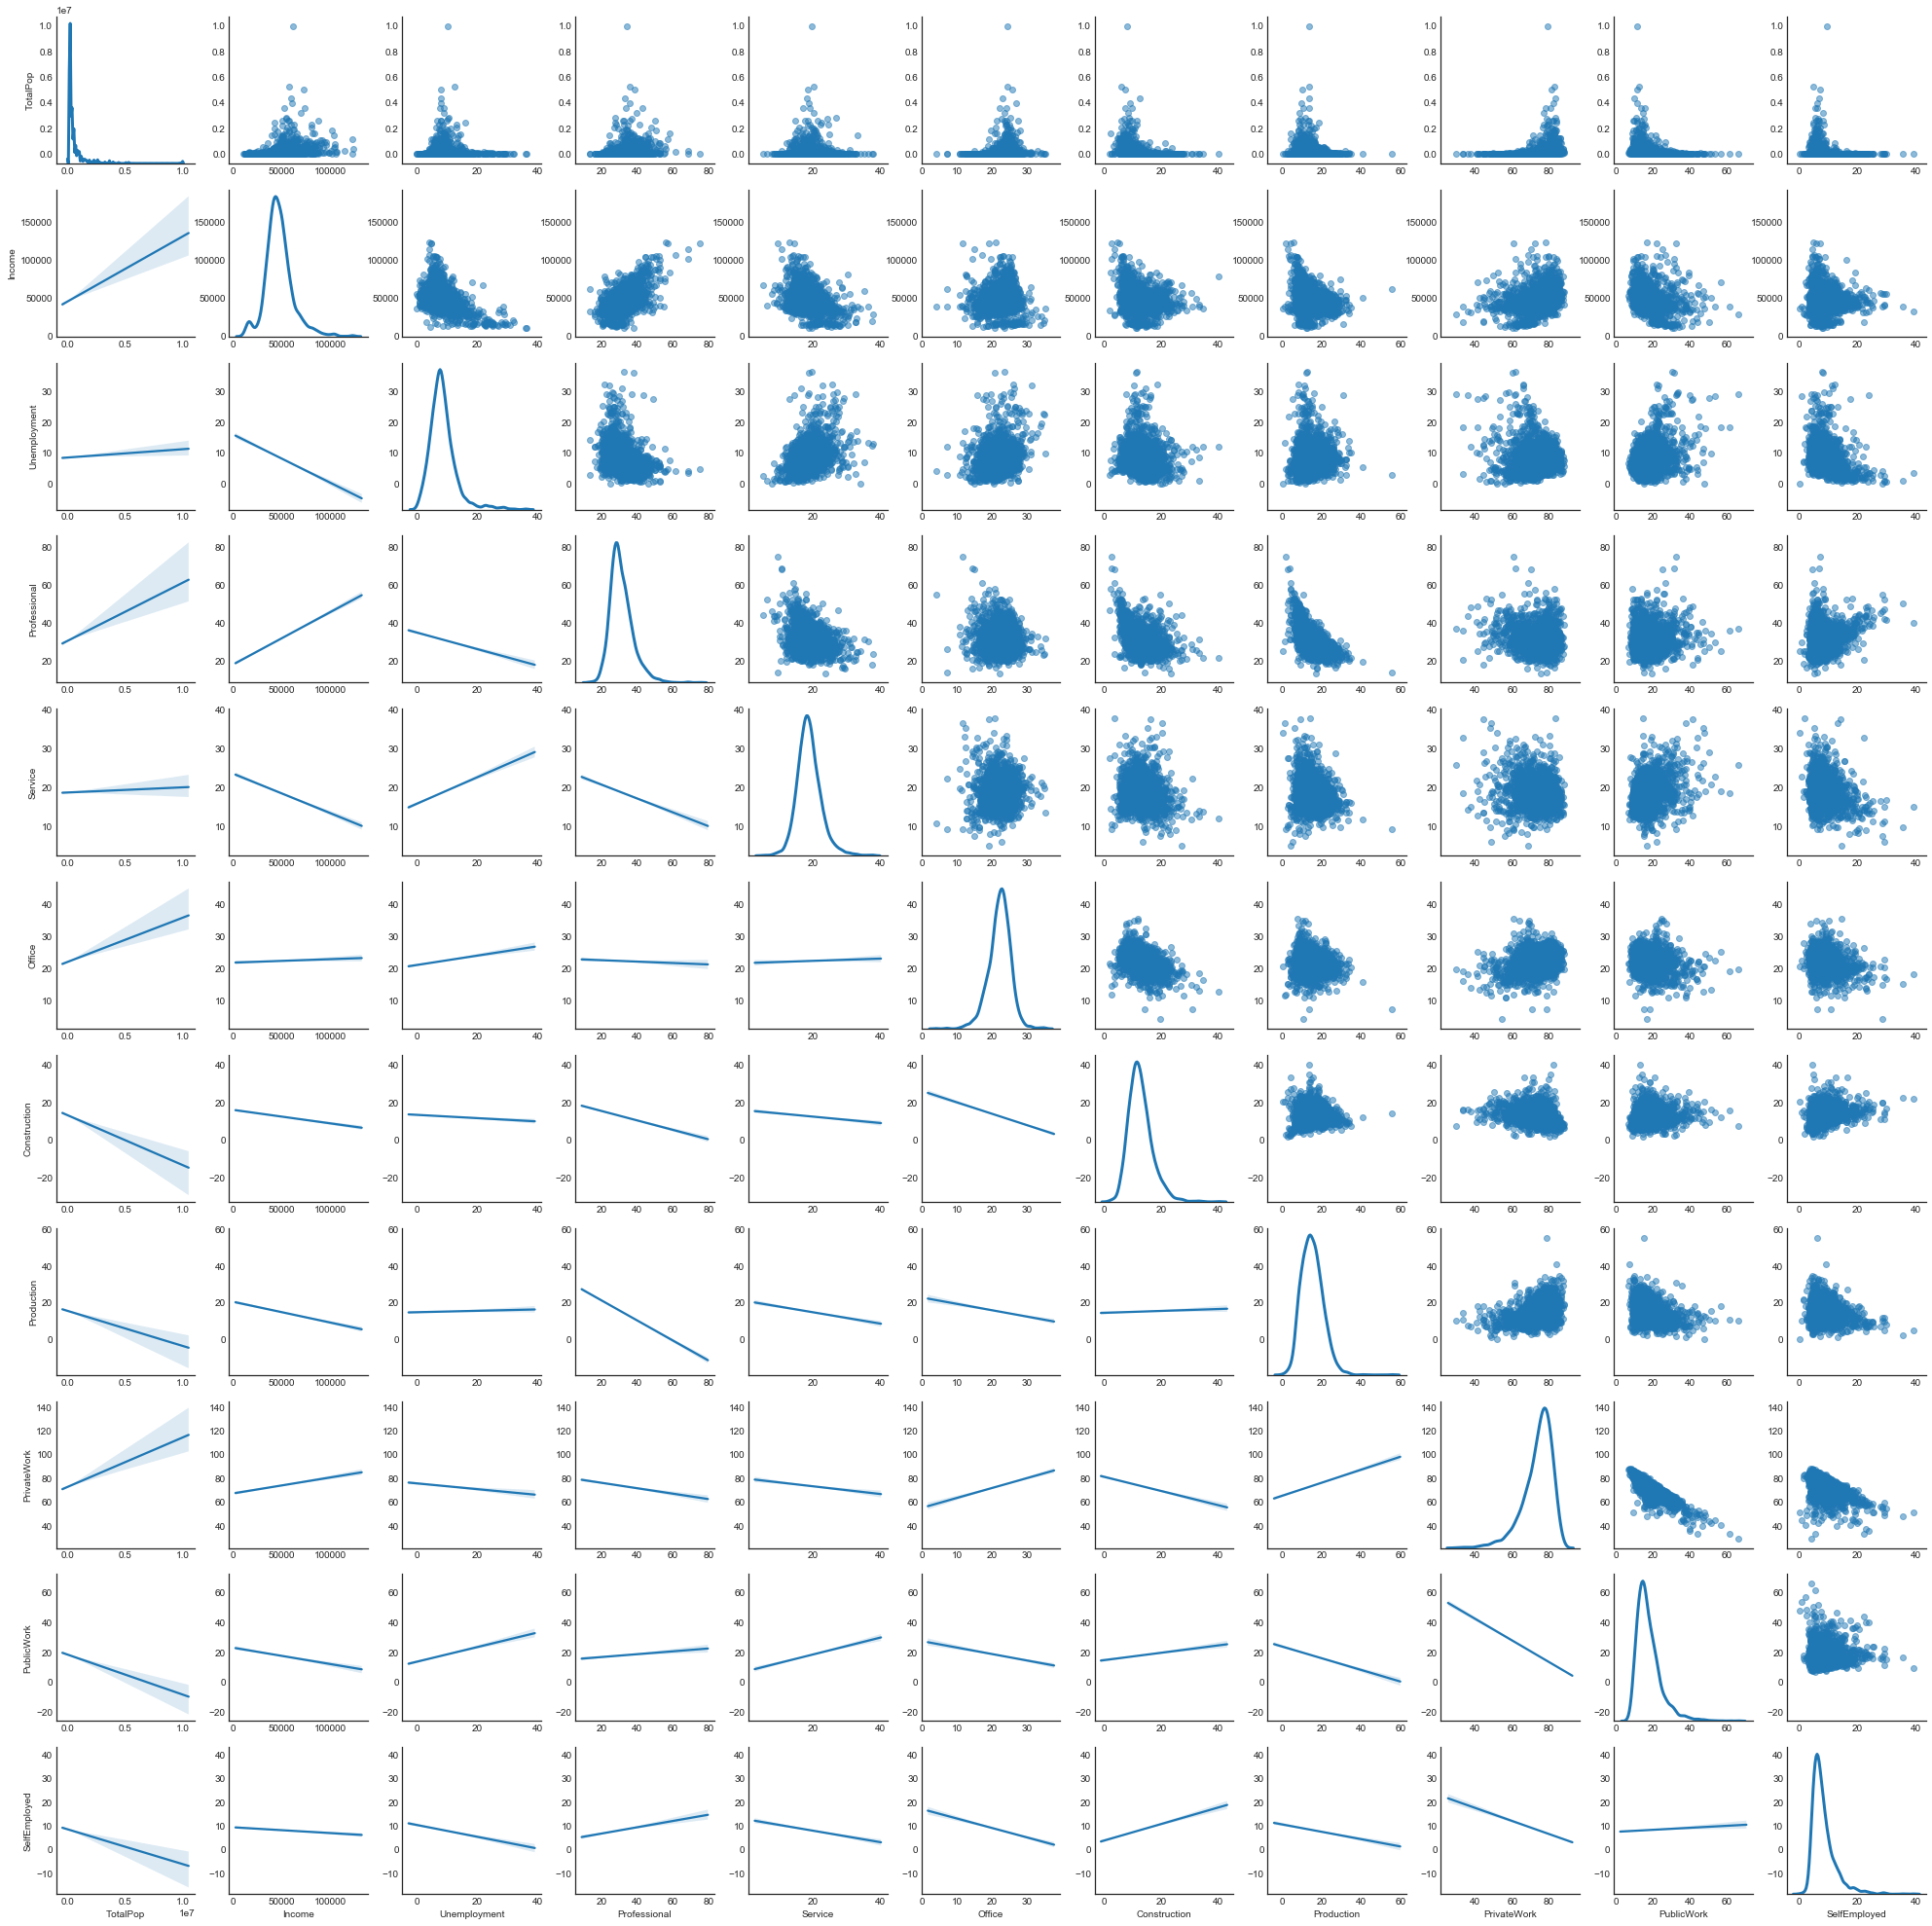

In [5]:
# Declare that you want to make a scatterplot matrix.
g = sns.PairGrid(dfc, diag_sharey=False)
# Scatterplot.
g.map_upper(plt.scatter, alpha=.5)
# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

## Calculate the covariance matrix and visualize correlation heatmap:

In [6]:
print('Covariance Matrix:\n')
dfC = dfc.corr()
dfC

Covariance Matrix:



,TotalPop,Income,Unemployment,Professional,Service,Office,Construction,Production,PrivateWork,PublicWork,SelfEmployed
TotalPop,1.000000,0.274464,0.027950,0.217995,0.016687,0.199838,-0.288708,-0.161835,0.235186,-0.182349,-0.167752
Income,0.274464,1.000000,-0.505351,0.611585,-0.396992,0.048405,-0.243645,-0.299100,0.236544,-0.232215,-0.086419
Unemployment,0.027950,-0.505351,1.000000,-0.299020,0.412373,0.204124,-0.091709,0.031367,-0.132421,0.321409,-0.273919
Professional,0.217995,0.611585,-0.299020,1.000000,-0.315084,-0.044918,-0.384759,-0.651709,-0.181865,0.091563,0.213067
Service,0.016687,-0.396992,0.412373,-0.315084,1.000000,0.039756,-0.145341,-0.206386,-0.145188,0.303458,-0.218045
Office,0.199838,0.048405,0.204124,-0.044918,0.039756,1.000000,-0.453907,-0.202110,0.324340,-0.202839,-0.313226
Construction,-0.288708,-0.243645,-0.091709,-0.384759,-0.145341,-0.453907,1.000000,0.040205,-0.309041,0.153858,0.364877
Production,-0.161835,-0.299100,0.031367,-0.651709,-0.206386,-0.202110,0.040205,1.000000,0.365687,-0.314311,-0.209041
PrivateWork,0.235186,0.236544,-0.132421,-0.181865,-0.145188,0.324340,-0.309041,0.365687,1.000000,-0.869442,-0.554793
PublicWork,-0.182349,-0.232215,0.321409,0.091563,0.303458,-0.202839,0.153858,-0.314311,-0.869442,1.000000,0.071339


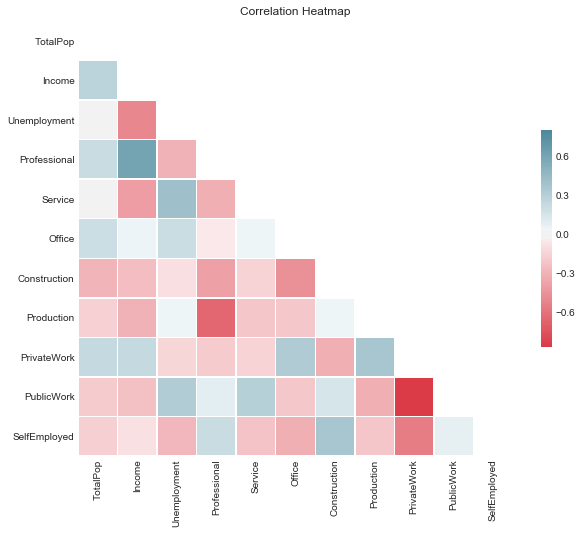

In [7]:
# Generate a mask for the upper triangle
mask = np.zeros_like(dfC, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(dfC, mask=mask, cmap=cmap, vmax=.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Heatmap')
plt.show()

## Inspecting for correlations greater than |0.7| and smaller than |0.1|:
Variables that are uncorrelated (values near zero) do not have shared information. Correlations that are too high can make components unstable.

In [8]:
dfC[((abs(dfC) > 0.8) & (abs(dfC) < 1)) | (abs(dfC) < .1)]

,TotalPop,Income,Unemployment,Professional,Service,Office,Construction,Production,PrivateWork,PublicWork,SelfEmployed
TotalPop,NaN,NaN,0.027950,NaN,0.016687,NaN,NaN,NaN,NaN,NaN,NaN
Income,NaN,NaN,NaN,NaN,NaN,0.048405,NaN,NaN,NaN,NaN,-0.086419
Unemployment,0.027950,NaN,NaN,NaN,NaN,NaN,-0.091709,0.031367,NaN,NaN,NaN
Professional,NaN,NaN,NaN,NaN,NaN,-0.044918,NaN,NaN,NaN,0.091563,NaN
Service,0.016687,NaN,NaN,NaN,NaN,0.039756,NaN,NaN,NaN,NaN,NaN
Office,NaN,0.048405,NaN,-0.044918,0.039756,NaN,NaN,NaN,NaN,NaN,NaN
Construction,NaN,NaN,-0.091709,NaN,NaN,NaN,NaN,0.040205,NaN,NaN,NaN
Production,NaN,NaN,0.031367,NaN,NaN,NaN,0.040205,NaN,NaN,NaN,NaN
PrivateWork,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.869442,NaN
PublicWork,NaN,NaN,NaN,0.091563,NaN,NaN,NaN,NaN,-0.869442,NaN,0.071339


## Conclusion:

- **Key metric of interest:**
    - to determine if a county's median income is correlated to its population size.


- ** Secondary metric of interest:**
    - to investigate if a county's jobs distribution by occupation affects median income.

The variable with the highest correlation to Income is Professional (0.611903), followed by Population (0.274607) and PrivateWork (0.236667).

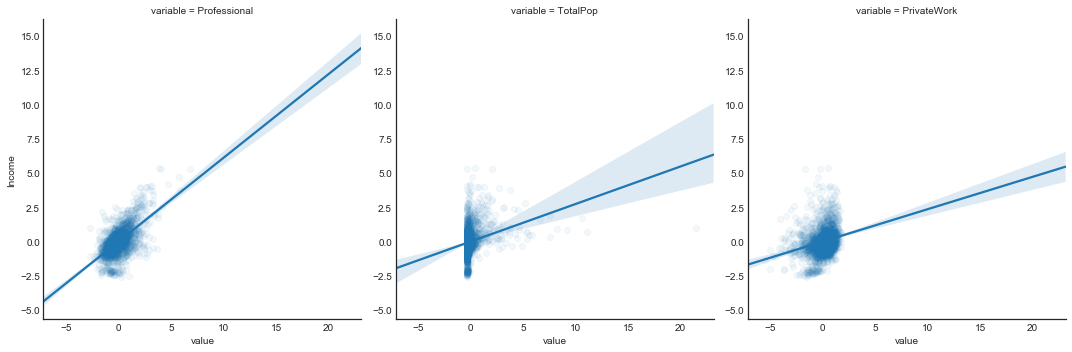

In [9]:
data_to_plot = pd.melt(
    dfs[['Income','Professional','TotalPop','PrivateWork']],
    id_vars='Income')

g = sns.lmplot(x="value", y="Income", data=data_to_plot, 
               scatter_kws=dict(alpha=.05),col="variable")

The positive correlation between Population and Income may be explained by the fact that Professional and Population also have significant correlation (0.218109). In other words, larger cities have greater proportions of people with Professional occupations.

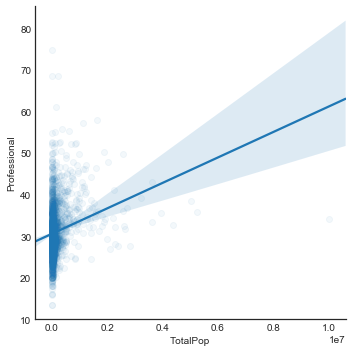

In [10]:
g = sns.lmplot(x="TotalPop", y="Professional", data=dfc,
               scatter_kws=dict(alpha=.05))

Also, there are four variables that are negatively correlated to both income and population, all of which related to the job market and occupation - PublicWork, SelfEmployed, Construction, and Production.

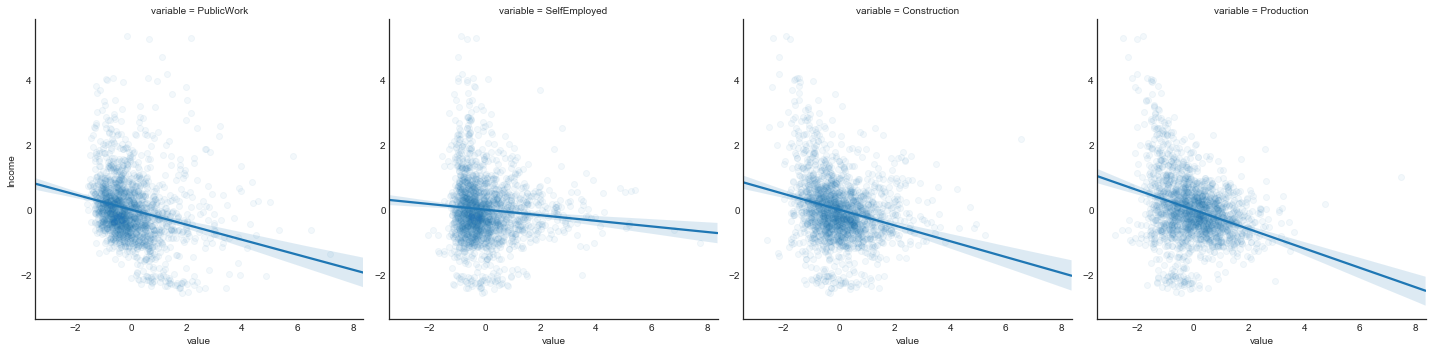

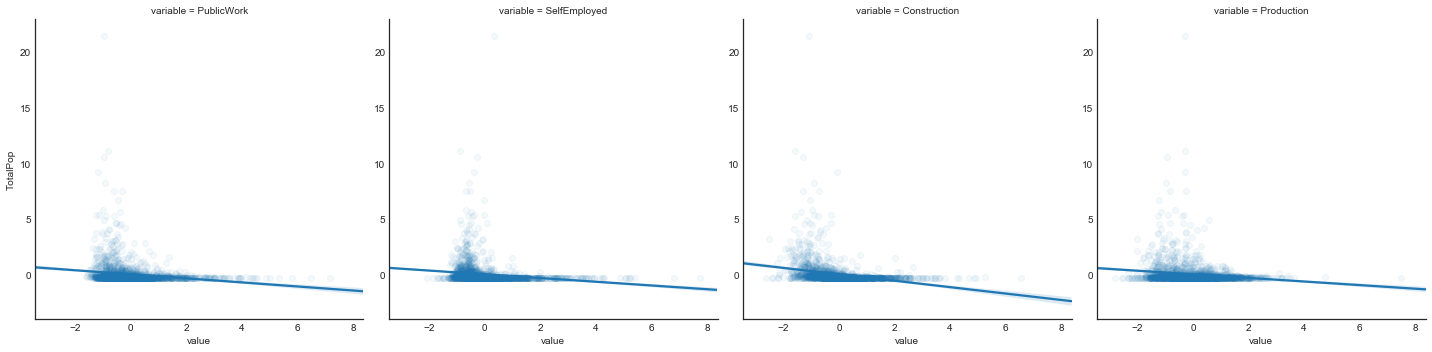

In [11]:
data_to_plot = pd.melt(
    dfs[['Income','PublicWork','SelfEmployed','Construction','Production']],
    id_vars='Income')

g = sns.lmplot(x="value", y="Income",
               data=data_to_plot, scatter_kws=dict(alpha=.05),col="variable")

data_to_plot = pd.melt(
    dfs[['TotalPop','PublicWork','SelfEmployed','Construction','Production']],
    id_vars='TotalPop')

g = sns.lmplot(x="value", y="TotalPop", data=data_to_plot,
               scatter_kws=dict(alpha=.05),col="variable")

**Indeed, population and income are positively correlated (key metric of interest), possibly due to the fact that bigger cities tend to have more professionals working in the private sector with higher paying jobs; and less people working in lower paying jobs such as production, construction, and public work.**

## Filtering features:

PublicWork and PrivateWork have a high level of negative correlation (-0.869894). PublicWork will be dropped.

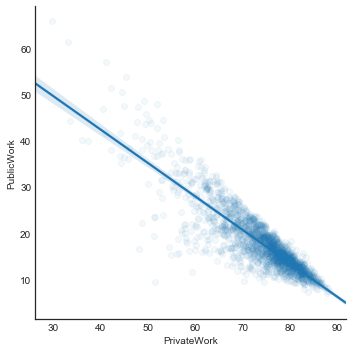

In [12]:
g = sns.lmplot(x="PrivateWork", y="PublicWork", data=dfc,
               scatter_kws=dict(alpha=.05))

Service and Office are both occupations with very little correlation and can be combined. The same with Construction and Production.

SelfEmployed and Income have correlation close to zero (-0.086419). SelfEmployed will be dropped.

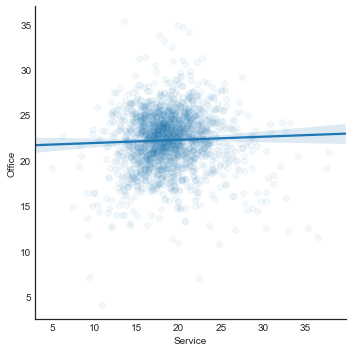

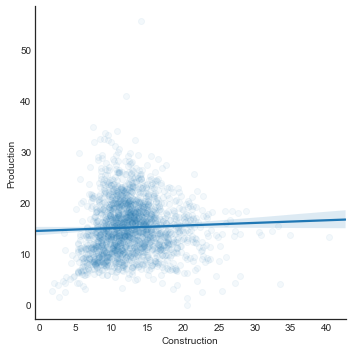

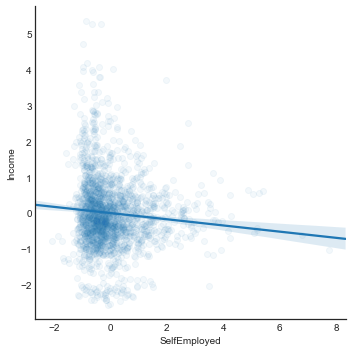

In [13]:
g = sns.lmplot(x="Service", y="Office", data=dfc, 
               scatter_kws=dict(alpha=.05))
g = sns.lmplot(x="Construction", y="Production", data=dfc, 
               scatter_kws=dict(alpha=.05))
g = sns.lmplot(x="SelfEmployed", y="Income", data=dfs, 
               scatter_kws=dict(alpha=.05))

Although Unemployment has a high negative correlation to Income, it has almost no correlation to Population, and will be dropped.

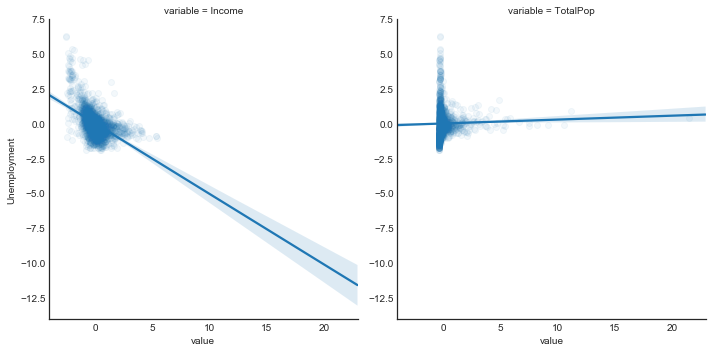

In [14]:
data_to_plot = pd.melt(
    dfs[['Income','Unemployment','TotalPop']],
    id_vars='Unemployment')

g = sns.lmplot(x="value", y="Unemployment", data=data_to_plot, 
               scatter_kws=dict(alpha=.05),col="variable")

In [15]:
# Average out variables with similar correlation:
dfs['serv_off'] = dfs[['Service','Office']].mean(axis=1)
dfs['prod_const'] = dfs[['Production','Construction']].mean(axis=1)

# Drop Unemployment and other unnecessary columns:
dfs = dfs.drop(columns=[
    'Unemployment','index_vals','PublicWork','Service','Office',
    'Production','Construction','SelfEmployed'])

In [16]:
dfC = dfs.corr()
dfC[((abs(dfC) > 0.8) & (abs(dfC) < 1)) | (abs(dfC) < .1)]

,TotalPop,Income,Professional,PrivateWork,serv_off,prod_const
TotalPop,NaN,NaN,NaN,NaN,NaN,NaN
Income,NaN,NaN,NaN,NaN,NaN,NaN
Professional,NaN,NaN,NaN,NaN,NaN,NaN
PrivateWork,NaN,NaN,NaN,NaN,NaN,0.039273
serv_off,NaN,NaN,NaN,NaN,NaN,NaN
prod_const,NaN,NaN,NaN,0.039273,NaN,NaN


Now PrivateWork and prod_const have close-to-zero correlation and will be averaged out:

In [17]:
dfs['priv_prod_const'] = dfs[['PrivateWork','prod_const']].mean(axis=1)
dfs = dfs.drop(columns=['PrivateWork','prod_const'])
dfC = dfs.corr()
dfC[((abs(dfC) > 0.8) & (abs(dfC) < 1)) | (abs(dfC) < .1)]

,TotalPop,Income,Professional,serv_off,priv_prod_const
TotalPop,NaN,NaN,NaN,NaN,0.007896
Income,NaN,NaN,NaN,NaN,-0.027736
Professional,NaN,NaN,NaN,NaN,NaN
serv_off,NaN,NaN,NaN,NaN,NaN
priv_prod_const,0.007896,-0.027736,NaN,NaN,NaN


So it turns out that PrivateWork, Production, and Construction were evening off themselves all along. The featre priv_prod_const is now uncorrelated with both population and income, and will be dropped.

The resulting dataframe has four variables with correlations between |0.15| and |0.61|.

In [18]:
dfs = dfs.drop(columns=['priv_prod_const'])
dfC = dfs.corr()
dfC

,TotalPop,Income,Professional,serv_off
TotalPop,1.000000,0.274464,0.217995,0.150150
Income,0.274464,1.000000,0.611585,-0.241730
Professional,0.217995,0.611585,1.000000,-0.249645
serv_off,0.150150,-0.241730,-0.249645,1.000000


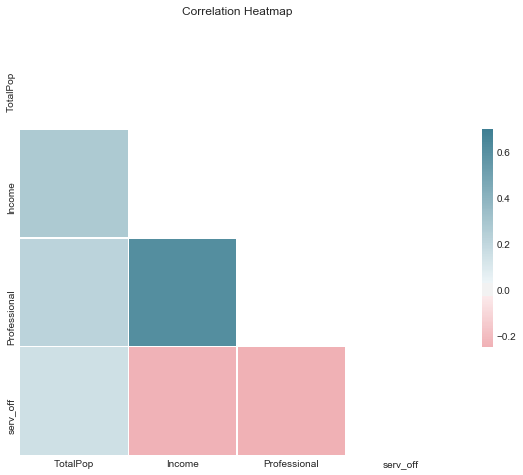

In [19]:
# Generate a mask for the upper triangle
mask = np.zeros_like(dfC, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(dfC, mask=mask, cmap=cmap, vmax=.7, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Heatmap')
plt.show()

In [20]:
# Calculating eigenvalues and eigenvectors.
eig_val_cov, eig_vec_cov = np.linalg.eig(dfC)

# Inspecting the eigenvalues and eigenvectors.
# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].reshape(1, 4).T
    print('Eigenvector {}: \n{}'.format(dfC.columns[i], eigvec_cov))
    print('Eigenvalue {}: {}'.format(dfC.columns[i], eig_val_cov[i]))
    print(40 * '-')

print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)

Eigenvector TotalPop: 
[[ 0.31216696]
 [ 0.63998388]
 [ 0.62962662]
 [-0.31071327]]
Eigenvalue TotalPop: 1.8529242001081254
----------------------------------------
Eigenvector Income: 
[[ 0.70685657]
 [ 0.02857709]
 [-0.03105409]
 [ 0.70609686]]
Eigenvalue Income: 1.1515078475337426
----------------------------------------
Eigenvector Professional: 
[[-0.62784265]
 [ 0.24199666]
 [ 0.37886064]
 [ 0.63538636]]
Eigenvalue Professional: 0.6107102427985402
----------------------------------------
Eigenvector serv_off: 
[[ 0.09337653]
 [-0.72872601]
 [ 0.67754747]
 [-0.03418557]]
Eigenvalue serv_off: 0.3848577095595913
----------------------------------------
The percentage of total variance in the dataset explained by each component calculated by hand.
 [ 0.46323105  0.28787696  0.15267756  0.09621443]


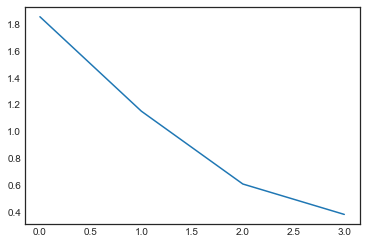

In [21]:
plt.plot(eig_val_cov)
plt.show()

Components Population and Income will be maintained, as they explain 75.1% of the total variance of the variables of interest of the dataset.

In [22]:
# Create P, which will be used to transform dfs into Cy to get Y, the
# dimensionally-reduced representation of X.
P = eig_vec_cov[:, 0]

# Transform X into Y.
Y = np.dot(P,dfs.T)

dfs['Component'] = Y.T

## Generate a correlation matrix including the dimensionally-reduced component and plot a heatmap:

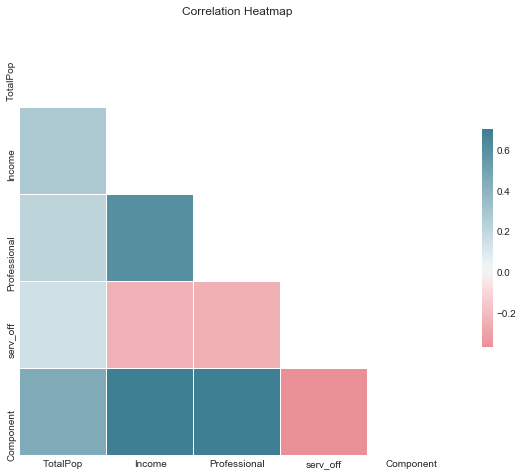

In [23]:
dfC = dfs.corr()

mask = np.zeros_like(dfC, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(dfC, mask=mask, cmap=cmap, vmax=.7, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Heatmap')
plt.show()

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [ 0.51043981  0.26558319  0.1155563   0.10842069]


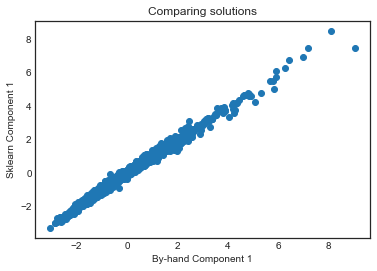

In [24]:
sklearn_pca = PCA(n_components=4)
Y_sklearn = sklearn_pca.fit_transform(dfs[['TotalPop', 'Income', 'Professional', 'serv_off']])

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

# Compare the sklearn solution to ours – not quite a perfect match.
plt.plot(Y_sklearn[:, 0], dfs['Component'], 'o')
plt.title('Comparing solutions')
plt.ylabel('Sklearn Component 1')
plt.xlabel('By-hand Component 1')
plt.show()